<a href="https://www.kaggle.com/code/mcpenguin/titanic-eda-and-prediction-lb-0-775?scriptVersionId=143235154" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

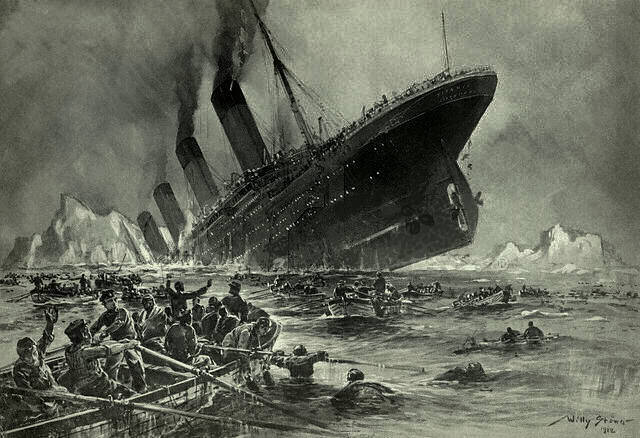

*Image credit: Willy Stower, from Wikipedia*

# 🚢 Titanic Competition - EDA and Prediction

In this notebook, we investigate the quintessential Titanic dataset, perform EDA, and predict whether the passengers survived in the test set.

# Import Libraries

In [ ]:
import numpy as np # linear algebra
from scipy.stats import randint, uniform
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from itertools import product

from IPython.display import display, Markdown

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from xgboost import XGBClassifier

In [ ]:
# suppress chained assignment warnings
pd.options.mode.chained_assignment = None

def _display(text):
    display(Markdown(text))

# Load Data

In [ ]:
INPUT_DIR = "/kaggle/input/titanic"

sample_submission = pd.read_csv(os.path.join(INPUT_DIR, "gender_submission.csv"))
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))

Let's see what these dataframes look like:

In [ ]:
train_df.head()

In [ ]:
test_df.head()

For ease later on in our EDA, let's make a `df_dict` object to "combine" these dataframes together, so that we minimize the amount of repeated code.

In [ ]:
df_dict = {}
df_dict["train"] = train_df
df_dict["test"] = test_df

# Feature Engineering

Before our EDA, we should investigate some of these variates and see if we should engineer any initial features for our dataset. We might also want to encode some of the categorical features into numeric ones, either through label or one-hot encodings, so that we can use these in our model.

## Cabin Number

Let's investigate what the non-missing values of the cabin number look like.

In [ ]:
df_dict["train"]["Cabin"].dropna().sample(20)

We see that the cabin number seems to be in various formats: `

* `<letter> <number>`;
* `<letter>`
* a space-separated string of one of the above options.

We should separate these into the cabin letter and cabin number. In the cases where its a space-separated string, we can probably just take the first cabin as our reference for the letter/number, as these cases are probably in the minority. That being said, another useful variate to include would be the number of cabins in the dataset. 

In fact, if the number of cabins is 0, then that signifies that no cabin information was included. This means the number of cabins serves as our "was cabin information missing?" flag in the data.

In [ ]:
def process_cabin(cabin):
    if not isinstance(cabin, float) and cabin is not None:
        cabin_split = str(cabin).split()
        cabin_count = len(cabin_split)
        cabin_first = cabin_split[0]
        letter = cabin_first[0]
        number = cabin_first[1:]
        if number == "":
            number = None
        return letter, number, cabin_count
    else:
        return None, None, 0

for name, df in df_dict.items():
    cabin_transformed = df["Cabin"].apply(process_cabin)
    df[["Cabin Letter", "Cabin Number", "Cabin Count"]] = pd.DataFrame(cabin_transformed.tolist(), index=df.index)
    df["Cabin Number"] = df["Cabin Number"].astype('float64')
    df["Cabin Count"] = df["Cabin Count"].astype('int64')
    

df_dict["train"].head()

# Initial Look At Data

## Describing Data

Let's view details about the dataset. 

In [ ]:
for name, df in df_dict.items():
    _display(f"### Details for {name} dataset")
    display(df.info())
    display(df.describe())

We see that for the training and test dataset, 

* the distributions of the numerical variates seem to be similar; and

* for the training and test dataset, no variates have no missing values except for `Cabin` and `Age`.

Given that a significant amount of the data have values for these variates, we should not drop data without these variates. Instead, we need to find a way to fill in these variates for the missing data.

# Explaratory Data Analysis

We can now explore the data. We will make sure to examine both the training and test datasets to see if there are any discrepancies in the data.

## Distributions of Numerical Variates

We can examine the distributions of the numerical variates, using histograms for both the training and test datasets.

In [ ]:
numerical_cols = ["Age", "SibSp", "Parch", "Fare"]

fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=2, figsize=(12,9))
plt.subplots_adjust(hspace=1)

for ax, (col, (name, df)) in zip(axes.flat, product(numerical_cols, df_dict.items())):
    sns.histplot(data=df, x=col, ax=ax)
    ax.set_title(f"Distribution of {col} in {name}")
    ax.set_yscale('log')

plt.show()

We see that for these numerical variates, the distributions of the data are roughly similar across the training and test datasets.

## Distribution of Categorical Variates

We can similarly analyze the distributions of the categorical variates, using countplots, for the training and test datasets.

In [ ]:
categorical_cols = ["Pclass", "Sex", "Embarked", "Cabin Letter"]

fig, axes = plt.subplots(nrows=len(categorical_cols), ncols=2, figsize=(12,12))
plt.subplots_adjust(hspace=0.5)

for ax, (col, (name, df)) in zip(axes.flat, product(categorical_cols, df_dict.items())):
    
    # for cabin letter, specify order for consistency
    if col == "Cabin Letter":
        order = ["A", "B", "C", "D", "E", "F", "G", "T"]
    elif col == "Embarked":
        order = ["S", "C", "Q"]
    else:
        order = None
        
    sns.countplot(data=df, x=col, ax=ax, order=order)
    ax.set_title(f"Distribution of {col} in {name}")

plt.show()

## Distribution of Cabins

We can investigate the distribution of cabin letter and number using a pairplot.

In [ ]:
ax1 = sns.jointplot(data=train_df.sort_values(by="Cabin Letter"), x="Cabin Letter", y="Cabin Number")
ax1.fig.suptitle("Cabin in Training Data")
ax1.fig.subplots_adjust(top=0.95) # Reduce plot to make room 

ax2 = sns.jointplot(data=test_df.sort_values(by="Cabin Letter"), x="Cabin Letter", y="Cabin Number")
ax2.fig.suptitle("Cabin in Test Data")
ax2.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
    
plt.show()

We also see that the distributions of the cabins are roughly similar as well.

# Label / One-Hot Encoding

We will also

* encode `Sex` using a label encoding by introducing a `isMale` variate (since there are only two genders in this dataset)

* encode `Embarked` using a one-hot encoding

* encode `CabinLetter` using a one-hot encoding

This will be useful for our modelling and visualizing correlations between the variates.

### Label Encoding of Gender

In [ ]:
train_df["IsMale"] = (train_df["Sex"] == "male")
test_df["IsMale"] = (test_df["Sex"] == "male")

### One-Hot Encoding of Embarked Location

In [ ]:
embarked_encoder = OneHotEncoder()
embarked_encoder.fit(train_df["Embarked"].values.reshape(-1, 1))

In [ ]:
embarked_locations = embarked_encoder.categories_[0]
for name, df in df_dict.items():
    cols = [f"Embarked {loc}" for loc in embarked_locations]
    df[cols] = embarked_encoder.transform(df["Embarked"].values.reshape(-1, 1)).toarray()

### One-Hot Encoding of Cabin Letter

In [ ]:
cabin_letter_encoder = OneHotEncoder()
cabin_letter_encoder.fit(train_df["Cabin Letter"].values.reshape(-1, 1))

In [ ]:
cabin_letters = cabin_letter_encoder.categories_[0]
for name, df in df_dict.items():
    cols = [f"Cabin Letter {letter}" for letter in cabin_letters]
    df[cols] = cabin_letter_encoder.transform(df["Cabin Letter"].values.reshape(-1, 1)).toarray()

### View Transformed Dataframe

Let's see the transformed dataframe after our encodings:

In [ ]:
train_df.head()

## Correlation Matrix

We can investigate the correlations between the variates for both the training and test datasets using correlation matrices.

In [ ]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(train_df.corr(numeric_only=True), annot=True, cmap="crest")
ax.set_title("Correlation matrix for Training dataset")
plt.show()

In [ ]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(test_df.corr(numeric_only=True), annot=True, cmap="crest")
ax.set_title("Correlation matrix for Test dataset")
plt.show()

# X-y Split

Before modelling, we need to split our training data to explanatory and response variates.

In [ ]:
explanatory_features = ['Pclass', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked S', 'Embarked Q', 'Embarked C', 'Embarked nan',
       'Cabin Number', 'Cabin Count', 'IsMale', 'Cabin Letter A',
       'Cabin Letter B', 'Cabin Letter C', 'Cabin Letter D', 'Cabin Letter E',
       'Cabin Letter F', 'Cabin Letter G', 'Cabin Letter T',
       'Cabin Letter None']
response_feature = "Survived"

X = train_df[explanatory_features]
y = train_df[response_feature]
X_test = test_df[explanatory_features]

Let's see how these look like. Note that we need all the values of `X` and `y` to be numeric or boolean.

In [ ]:
X.head()

In [ ]:
y.head()

## Filling in Missing Values

In order to pass our data in to our models, we need to fill in missing values. We can check which columns in our "X" dataframe have missing values:

In [ ]:
X.isna().sum()[lambda x: x>0]

In [ ]:
X_test.isna().sum()[lambda x: x>0]

As we can see, it is only the age, cabin number and fare that contain missing variates. As such, it suffices to fill these in with dummy values.

In [ ]:
for X_ in [X, X_test]:
    X_["Age"] = X_["Age"].fillna(0)
    X_["Fare"] = X_["Fare"].fillna(0)
    X_["Cabin Number"] = X_["Cabin Number"].fillna(0)

# Modelling

We will be comparing the performance of various classification models on the dataset using stratified K-Fold cross-validation.

In [ ]:
models = {
    "ada_boost": AdaBoostClassifier(random_state=42),
    "random_forest": RandomForestClassifier(random_state=42),
    "gradient_boosting": GradientBoostingClassifier(random_state=42),
    "hist_gradient_boosting": HistGradientBoostingClassifier(random_state=42),
    "k_neighbors": KNeighborsClassifier(),
    "svc": SVC(random_state=42),
    "xgb": XGBClassifier(random_state=42),
}

# Training

In [ ]:
def create_pipeline(name, model):
    return Pipeline([
        ('scaler', StandardScaler()),
        (name, model)
    ])

n_splits = 8
skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state=42)
best_loss = np.inf
best_model_name = None

for name, model in models.items():
    print("-"*25)
    print(f"Training MODEL {name}")
    print("-"*25)
    val_losses = []
    
    for i, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"Training on FOLD {i+1}")
        X_train = X.iloc[train_index].values
        X_val = X.iloc[val_index].values
        y_train = y.iloc[train_index].values.ravel()
        y_val = y.iloc[val_index].values.ravel()
        
        pipe = create_pipeline(name, model)
        
        pipe.fit(X_train, y_train)
        y_train_pred = pipe.predict(X_train)
        train_loss = log_loss(y_train, y_train_pred)
        print(f"Loss on training set: {train_loss}")
        
        y_val_pred = pipe.predict(X_val)
        val_loss = log_loss(y_val, y_val_pred)
        print(f"Loss on validation set: {val_loss}")
        print()
        
        val_losses.append(val_loss)
        
    average_loss = np.mean(val_losses)
    print(f"Average loss: {average_loss}")
    if average_loss < best_loss:
        best_loss = average_loss
        best_model_name = name

print()
print(f"Best model: {best_model_name}")
print(f"Loss: {best_loss}")

# Hyperparameter Tuning

To improve performance of our model, we can tune the model hyperparameters.

In [ ]:
pipeline = create_pipeline("xgb", XGBClassifier())
param_grid = {
    "xgb__learning_rate": uniform(0.001, 0.3),
    "xgb__subsample": [0.5, 0.7, 1],
    "xgb__n_estimators": randint(low=30, high=500),
}
search = RandomizedSearchCV(pipeline, param_grid, n_iter=30, cv=5, random_state=42)

search.fit(X, y.values.ravel())

We can check the best parameters in the search:

In [ ]:
search.best_params_

# Feature Importance

As the model we used in our pipeline was a decision-tree based model, something else we could look at is the importance of features.

In [ ]:
best_pipeline = search.best_estimator_
feature_importances = best_pipeline.named_steps["xgb"].feature_importances_
feature_df = pd.DataFrame({"name": explanatory_features, "importance": feature_importances})
feature_df = feature_df.sort_values(by="importance", ascending=False)

plt.figure(figsize=(20, 8))
plt.xticks(rotation = 90)

ax = sns.barplot(data=feature_df, x="name", y="importance")
plt.show()

# Prediction

We can now use our model to predict the test set.

In [ ]:
best_pipeline = search.best_estimator_
test_df[response_feature] = best_pipeline.predict(X_test)
test_df.head()

# Submission

In [ ]:
test_df[["PassengerId", "Survived"]].to_csv("submission.csv", index=False)